In [1]:
import sys
sys.path.append('/home/nick/workspace/zoo-aquifer')

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import processor
from scipy import stats

### Process GWIC data

In [2]:
# Get gwicids and associated metadata
gwic_filename = '../data/missoula_valley_monitored_wells.csv'
gwicids = pd.read_csv('../data/mso_monitoring_wells_list_mso_only.csv')['gwicid'].values
all_metadata = gpd.read_file('~/MEGA/business/adaptivehydro/projects/Missoula_City/Aquifer_Sustainability_Study/data/GWAAMON_Wells/Shapefile/GWAAMON_Wells.shp')
df_meta = all_metadata.loc[all_metadata['gwicid'].isin(gwicids)]
df_meta.to_csv('../data/gwic_site_metadata_mso_only.csv', index=False)

In [57]:
# Retrieve GWIC data
GWIC = processor.GWIC(gwicids)
gwic_data = GWIC.get_all_data(filename=gwic_filename, check_file=False, outliers_std=4)

Processing data for well 67037
Processing data for well 69402
Processing data for well 136400
Processing data for well 151061
Processing data for well 151101
Processing data for well 151143
Processing data for well 151161
Processing data for well 151179
Processing data for well 151188
Processing data for well 151189
Processing data for well 151190
Processing data for well 151191
Processing data for well 157208
Processing data for well 157211
Processing data for well 209148
Processing data for well 209254
Processing data for well 209255


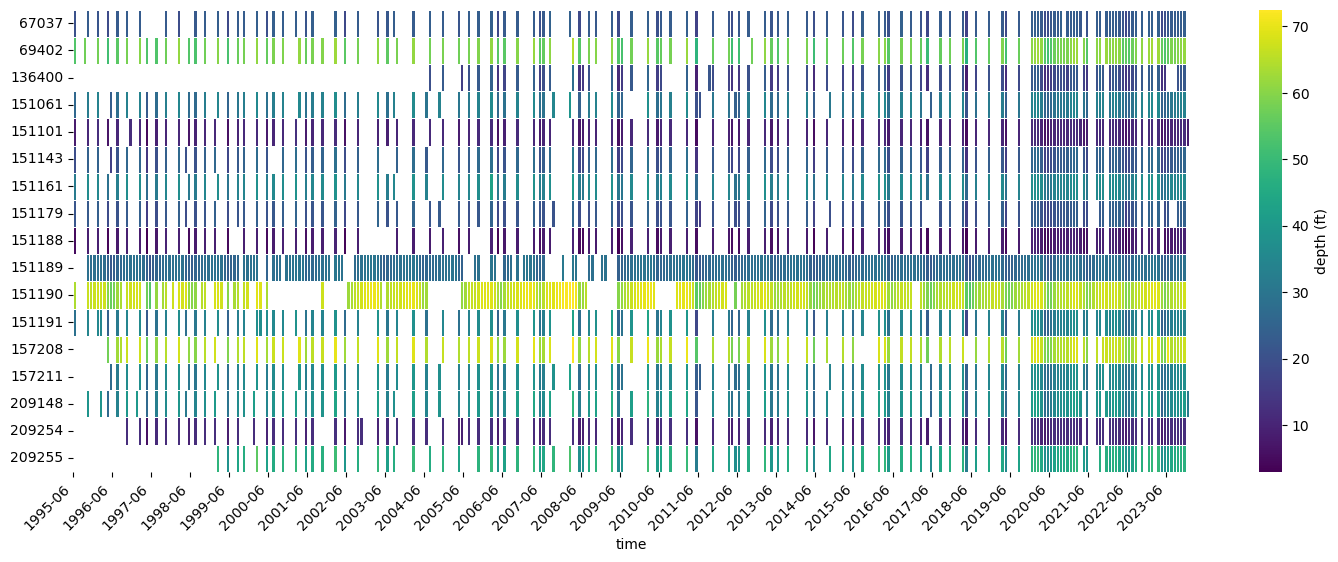

In [58]:
# Plot gwic data heatmap
fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(gwic_data.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = gwic_data.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

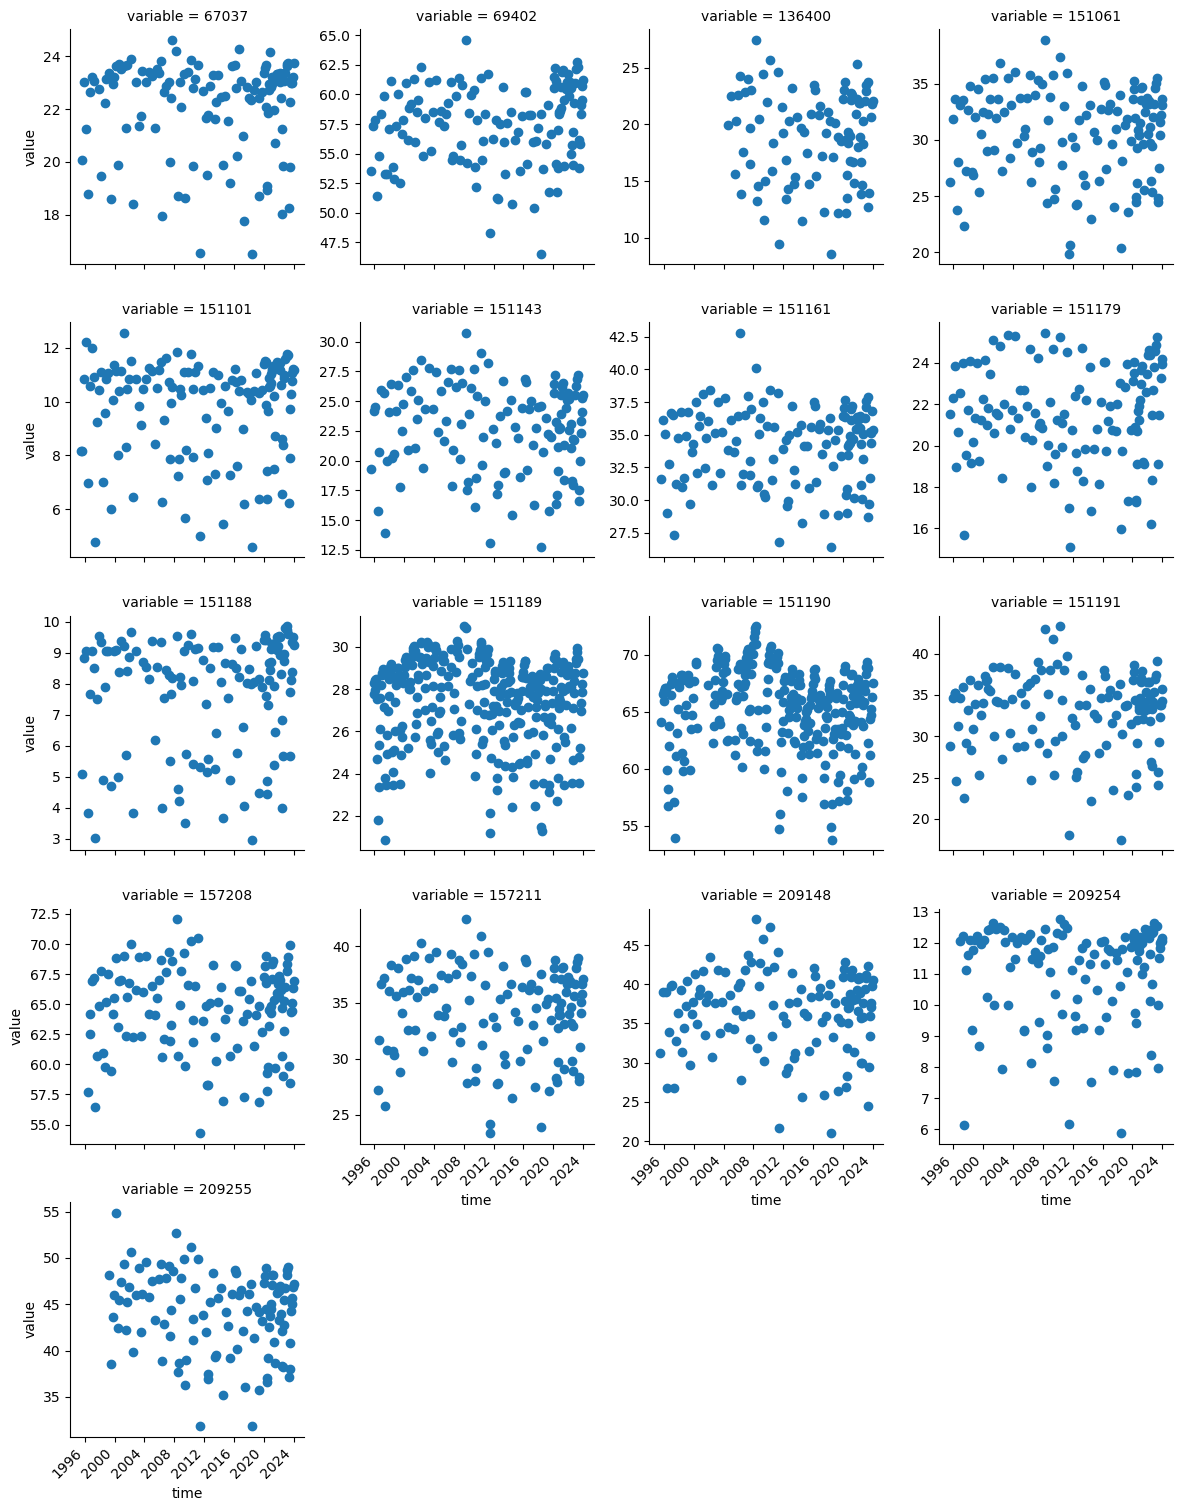

In [59]:
gwic_melt = gwic_data.reset_index().melt(id_vars='time')
g = sns.FacetGrid(gwic_melt, col='variable', col_wrap=4, sharey=False, sharex=True)
g.map(plt.scatter, 'time', 'value')
# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
plt.show()

In [60]:
# Remove stations with insufficient or weird data and overwrite file
dropids = [274392, 136400, 151203, 157207, 151204]
gwic_data = gwic_data.drop(columns=dropids, errors='ignore')
gwic_data.to_csv(gwic_filename, index=True)

### Process USGS streamflow data

<Axes: xlabel='time'>

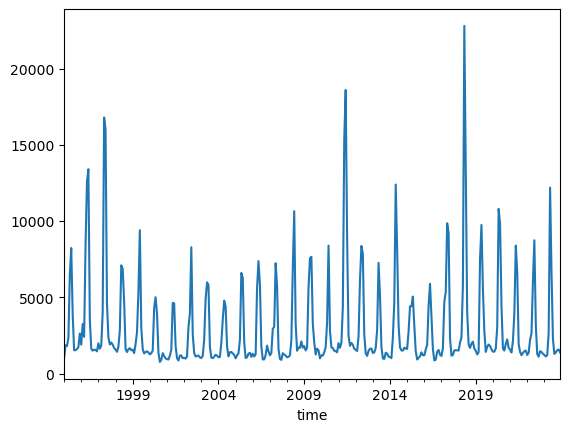

In [61]:
# Retrieve USGS data
clk_fk_avb_mso = '12340500'
usgs_filename = './data/clark_fk_above_missoula_q.csv'
USGS = processor.USGS(clk_fk_avb_mso)
usgs_data = USGS.get_all_data(filename=usgs_filename, check_file=True)
usgs_data.plot(kind='line', legend=False)

### Impute groundwater data to fill gaps

<Axes: xlabel='time'>

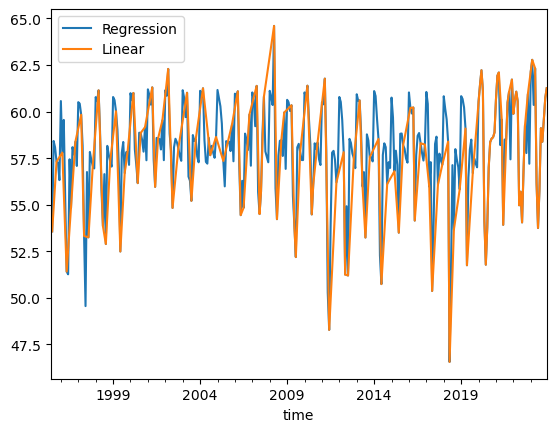

In [62]:
df = pd.concat([usgs_data, gwic_data], axis=1, join='inner')
Imputer = processor.Imputer(df)
df_reg = Imputer.q_and_doy_regression()
df_lin = Imputer.linear()
df_reg.to_csv('./data/missoula_valley_wells_imputed_qreg.csv')
df_lin.to_csv('./data/missoula_valley_wells_imputed_lin.csv')
df_reg.iloc[:, 2].plot(label='Regression', legend=True)
df_lin.iloc[:, 2].plot(label='Linear', legend=True)

### Build dynamic variables
For model inputs we will standardize streamflow and pumping rates using the zscore while leaving the groundwater data raw.
We will create an additional dataframe analysis of all normalized (minmax) values.  

In [63]:
# Process streamflow data
reg_method = 'qreg'  # 'lin' or 'qreg'
reg_fname = './data/missoula_valley_wells_imputed_' + reg_method + '.csv'
if reg_method == 'lin':
    if 'df_lin' not in globals():
        df_lin = pd.read_csv(reg_fname, index_col=0)
    df_dyn = df_lin.copy()
    df_norm = df_lin.copy()
elif reg_method == 'qreg':
    if 'df_reg' not in globals():
        df_reg = pd.read_csv(reg_fname, index_col=0)
    df_dyn = df_reg.copy()
    df_norm = df_reg.copy()

# prepare norm dataset
depth_cols = [i for i in df_norm.columns if not i in ['time', 'Q', 'pumping_rate']]
for col in depth_cols:
    df_norm[col] *= -1 

# normalize   
df_dyn['Q'] = stats.zscore(df_dyn['Q'])
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())
df_dyn.index = pd.to_datetime(df_dyn.index)
df_norm.index = pd.to_datetime(df_norm.index)

# shift index to the beginning of the month
df_dyn.index = df_dyn.index.shift(-1, freq='MS')
df_norm.index = df_norm.index.shift(-1, freq='MS')

In [64]:
# Process city pumping data
pumping_data = pd.read_csv('./data/mso_monthly_pumping_rates.csv')
pumping_data.index = pd.to_datetime(pumping_data['yrmo'], format='%b %Y')
min_vol = pumping_data['vol_Mg'].min()
max_vol = pumping_data['vol_Mg'].max()
pumping_data['vol_minmax'] = (pumping_data['vol_Mg'] -  min_vol)/(max_vol - min_vol)
pumping_data['vol_zscore'] = stats.zscore(pumping_data['vol_Mg'])
df_dyn = pd.concat([pumping_data['vol_zscore'], df_dyn], axis=1, join='inner')
df_dyn.rename(columns={'vol_zscore': 'pumping_rate'}, inplace=True)
df_norm = pd.concat([pumping_data['vol_minmax'], df_norm], axis=1, join='inner')
df_norm.rename(columns={'vol_minmax': 'pumping_rate'}, inplace=True)
df_norm.to_csv('./data/dynamic_variables_all_normalized.csv')


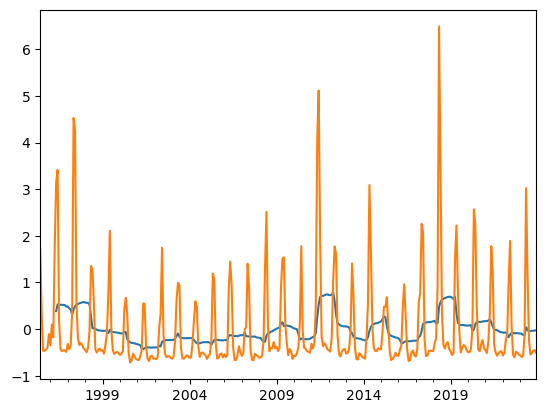

In [65]:
# Moving window for pumping and discharge data
window = 12 
# window labels are right edge of window index (see center=False in rolling)
df_dyn['Q_win'] = df_dyn['Q'].rolling(window=window).mean()
df_dyn['pumping_rate_win'] = df_dyn['pumping_rate'].rolling(window=window).mean()
df_dyn['Q_win'].plot()
df_dyn['Q'].plot()
df_dyn.columns
df_dyn.to_csv('./data/dynamic_variables_norm.csv')

### Build static variables

In [71]:
# Select static variables from meta data
svars = ['gwicid', 'latitude', 'longitude', 'altitude', 'total_dept', 'swl']
if 'df_meta' not in globals():
    df_meta = pd.read_csv('./data/gwic_site_metadata.csv')
df_svars = df_meta[svars]
df_svars = df_svars.set_index('gwicid')

In [72]:
# Create static variables based on location
df_pts = pd.read_csv('./data/input_output_locations.csv', index_col='desc')
gdf_pts = gpd.GeoDataFrame(df_pts, 
                           geometry=gpd.points_from_xy(df_pts.longitude, 
                                                       df_pts.latitude),
                           crs="EPSG:4326")
gdf_pts = gdf_pts.to_crs(epsg=32100)
gdf_svars = gpd.GeoDataFrame(df_svars, 
                           geometry=gpd.points_from_xy(df_svars.longitude, 
                                                       df_svars.latitude),
                           crs="EPSG:4326")
gdf_svars = gdf_svars.to_crs(epsg=32100)
df_dist = gdf_svars.geometry.apply(lambda x: gdf_pts.distance(x))
df_svars = pd.concat([df_svars, df_dist], axis=1, join='inner')

In [73]:
# Create static ksat variable from SSURGO
# https://www.nrcs.usda.gov/sites/default/files/2022-08/SSURGO-Metadata-Table-Column-Descriptions-Report.pdf
shp_path = './data/bbox.shp'
prop = 'ksat_r'
ssurgo = processor.SSURGO(shp_path, gdf_svars)
df_soil = ssurgo.get_all_data(prop)
df_svars = pd.concat([df_svars, df_soil[prop]], axis=1, join='inner')
df_svars.to_csv('./data/static_variables.csv')

In [74]:
# Normalize static variables between 0 and 1
df_svars_norm = df_svars.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_svars_norm.to_csv('./data/static_variables_norm.csv')